In [9]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver



[[-58.99140697 -58.82210402 -58.65201549 ...  81.66135505  81.72064934
   81.77967268]
 [-59.13870038 -58.96953491 -58.7995809  ...  81.73901563  81.79814539
   81.85700436]
 [-59.28634813 -59.1173236  -58.94750757 ...  81.81671129  81.87567566
   81.93436939]
 ...
 [-65.35173607 -65.2345472  -65.11688001 ...  69.52264016  69.62294335
   69.72282942]
 [-65.26533147 -65.14811171 -65.03041502 ...  69.41116073  69.5116527
   69.61172798]
 [-65.1791398  -65.06189033 -64.9441653  ...  69.29977792  69.40045718
   69.50072016]]


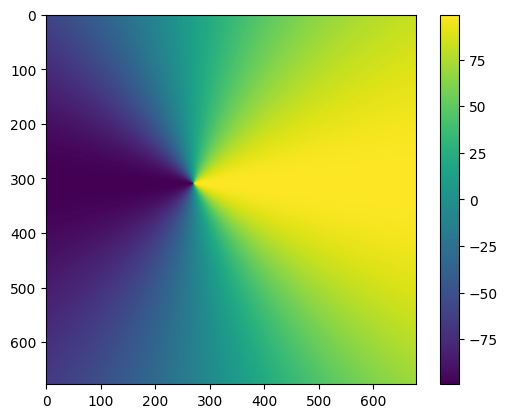

In [17]:
#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
%matplotlib inline


# import the LensModel class #
from lenstronomy.LensModel.lens_model import LensModel

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.2, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))
# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape) #(y,x)
alpha_y_2d = alpha_y.reshape(x_grid.shape) #(y,x)


plt.imshow(alpha_x_2d)
plt.colorbar()
print(alpha_x_2d)

In [18]:
#testing image position function

# make a point source
coord = (260.4,305.9)
def find_rough_def_pix(coord):  
    coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
    y_round, x_round = round(coord[1]), round(coord[0])

    # Pre-calculate possible matching rounded values for efficiency
    y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
    x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

    coordinates = []
    n = 0

    # Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
    for i in range(size):
        for j in range(size):
            ycoord, xcoord = i - alpha_y_2d[i, j], j - alpha_x_2d[i, j]
            if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
                coordinates.append((j, i))  # (x, y)
                n += 1

    #plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='r', s=1)
    #plt.scatter(coord[0], coord[1], c='b', s=1)
    
    return coordinates
coordinates = find_rough_def_pix(coord)
print(coordinates)

[(294, 209), (295, 209), (296, 210), (297, 210), (298, 210), (299, 210), (300, 211), (217, 223), (218, 223), (215, 224), (216, 224), (214, 225), (215, 225), (213, 226), (168, 355), (169, 356), (169, 357), (169, 358), (170, 359), (334, 361), (334, 362)]


Number of pixels: [7, 7, 5, 2]


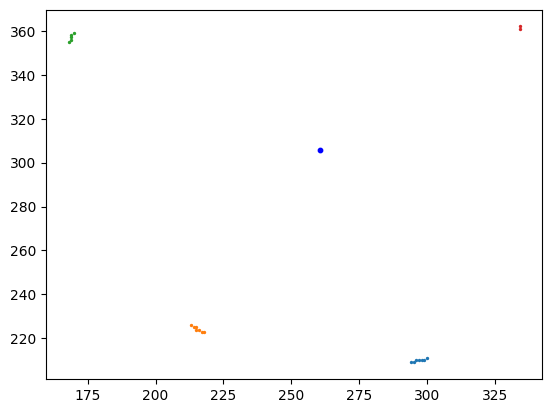

In [6]:
coordinates = np.array(coordinates)

#DBSCAN clustering

dbscan = DBSCAN(eps=3, min_samples=1).fit(coordinates)
labels = dbscan.labels_
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=2)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')
plt.scatter(coord[0], coord[1], c='b', s=10)

In [7]:
# interpolate the deflected angle given the image pos
alpha_x_2d = np.array(alpha_x_2d, dtype=np.float64)
alpha_y_2d = np.array(alpha_y_2d, dtype=np.float64)
def def_angle_test_interpolate(x,y, alpha_x= alpha_x_2d, alpha_y = alpha_y_2d):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)

Image 1 position: [169.47760856 357.05303487]
Predicted Image 1 position: [169.47651334 357.05138811]
Difference: 0.00197770122791021
Image 2 position: [213.51079691 225.73301739]
Predicted Image 2 position: [213.50998689 225.73193223]
Difference: 0.001354139706779922
Image 3 position: [299.78631957 210.49632839]
Predicted Image 3 position: [299.78654576 210.49565535]
Difference: 0.0007100309151506525
Image 4 position: [333.54762398 362.22817304]
Predicted Image 4 position: [333.54791639 362.23071255]
Difference: 0.0025562940244308495


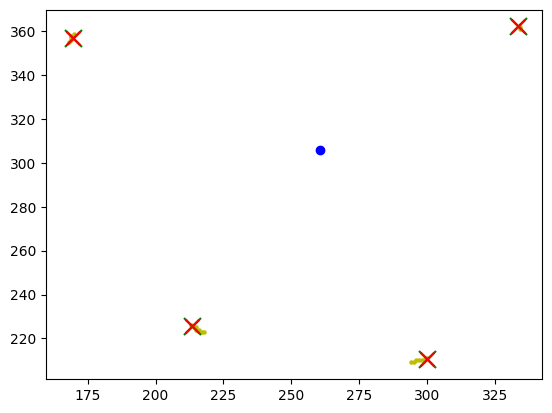

In [16]:
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0], coord[1], c='b')
plt.scatter([i[0] for i in coordinates], [i[1] for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
img = [[] for _ in range(len(images))]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize(diff_interpolate, img_guess, bounds =[(x_min-1, x_max+1), (y_min-1, y_max+1)], method='L-BFGS-B', tol=1e-8) # the 1 is for wider boundary
    #print(x_min, x_max, y_min, y_max, pos.x, diff_interpolate(pos.x))
    #plt.scatter(pos.x[0], pos.x[1], c='g', s=10, marker='x')
    img[i] = pos.x

img = np.array(img)
sorted_img = sorted(img, key=lambda x: x[0])

solver = LensEquationSolver(lensModel)
pixscale = 0.25
# solve for image positions provided a lens model and the source position #
img_x, img_y = solver.image_position_analytical(coord[0],coord[1], kwargs_lens)
img_analytical = [[] for _ in range(len(images))]
for i in range(len(images)):
    img_analytical[i] = img_x[i], img_y[i]
img_analytical = np.array(img_analytical)
sorted_img_analytical = sorted(img_analytical, key=lambda x: x[0])

plt.scatter(img_x , img_y, c='r', s=100, marker='x')
for i in range(len(sorted_img)):
    plt.scatter(sorted_img[i][0],sorted_img[i][1], c='g', s=150, marker='x')
    plt.scatter(sorted_img_analytical[i][0],sorted_img_analytical[i][1], c='r', s=100, marker='x')

for i in range(len(img_x)):
    print(f'Image {i+1} position: {sorted_img[i]}')
    print(f'Predicted Image {i+1} position: {sorted_img_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_img[i][0]-sorted_img_analytical[i][0])**2 + (sorted_img[i][1]-sorted_img_analytical[i][1])**2)}')   